In [1]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

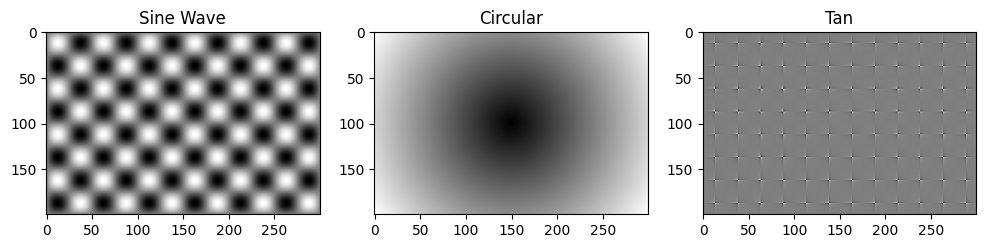

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D sine wave pattern
height, width = 200, 300
y, x = np.mgrid[0:height, 0:width]

# Create patterns using coordinates
sine_wave = np.sin(2 * np.pi * x / 50) * np.sin(2 * np.pi * y / 50)
tan_wave = np.tan(2 * np.pi * x / 50) * np.tan(2 * np.pi * y / 50)
circular_pattern = np.sqrt((x - width/2)**2 + (y - height/2)**2)
checkerboard = ((x // 20) + (y // 20)) % 2

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(sine_wave, cmap='gray'); plt.title('Sine Wave')
plt.subplot(132); plt.imshow(circular_pattern, cmap='gray'); plt.title('Circular')
# plt.subplot(133); plt.imshow(checkerboard, cmap='gray'); plt.title('Checkerboard')
plt.subplot(133); plt.imshow(tan_wave, cmap='gray'); plt.title('Tan')
plt.show()

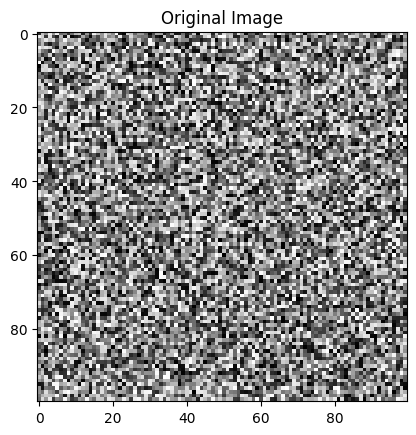

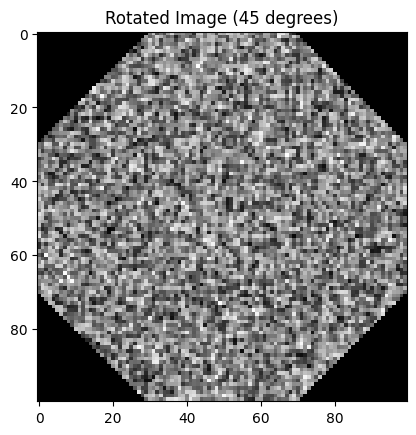

In [32]:
# Rotate an image using coordinate transformation
def rotate_image_coordinates(image, angle_degrees):
    h, w = image.shape
    y, x = np.mgrid[0:h, 0:w]
    
    # Convert to centered coordinates
    center_x, center_y = w/2, h/2
    x_centered = x - center_x
    y_centered = y - center_y
    
    # Rotation matrix
    angle_rad = np.radians(angle_degrees)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    
    # Apply rotation
    x_rot = cos_a * x_centered - sin_a * y_centered + center_x
    y_rot = sin_a * x_centered + cos_a * y_centered + center_y
    
    # Interpolate to get rotated image
    from scipy import ndimage
    rotated = ndimage.map_coordinates(image, [y_rot, x_rot], order=1, cval=0)
    return rotated

# Example usage
original = np.random.random((100, 100))
rotated = rotate_image_coordinates(original, 45)

plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.figure()
plt.imshow(rotated, cmap='gray')
plt.title('Rotated Image (45 degrees)')
plt.show()

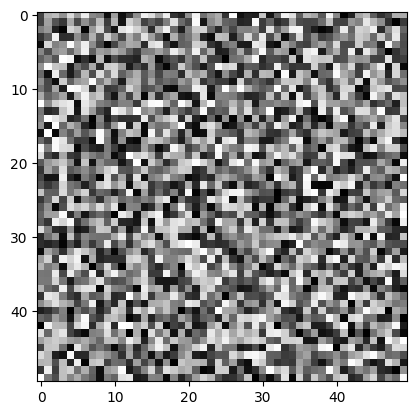

In [38]:
im = np.random.random((50, 50))
plt.imshow(im, cmap='gray')

In [39]:
im

array([[0.26801843, 0.69717856, 0.7428775 , ..., 0.28079573, 0.68497165,
        0.67128765],
       [0.25843759, 0.63008258, 0.32937624, ..., 0.19186465, 0.01485519,
        0.23385856],
       [0.49911753, 0.59478126, 0.13097865, ..., 0.54425378, 0.86901511,
        0.39936431],
       ...,
       [0.70452792, 0.71698056, 0.31389462, ..., 0.86951376, 0.68901047,
        0.09420304],
       [0.20585053, 0.92847755, 0.2419912 , ..., 0.13500141, 0.00765222,
        0.57696095],
       [0.99495857, 0.46747034, 0.30165725, ..., 0.54191471, 0.41956376,
        0.97619564]], shape=(50, 50))

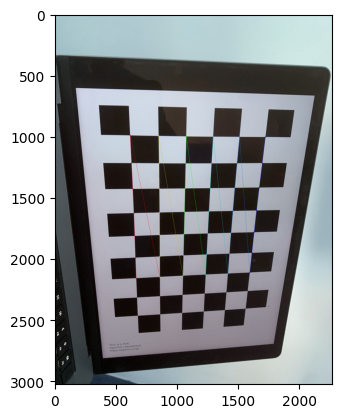

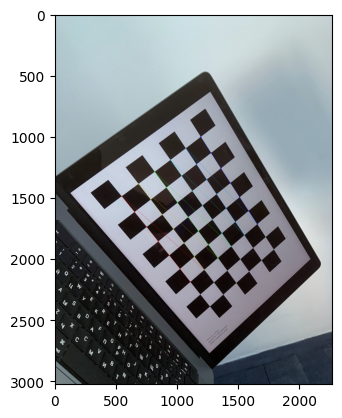

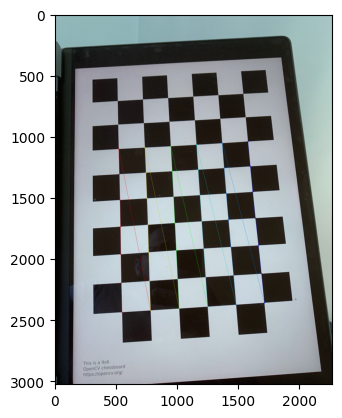

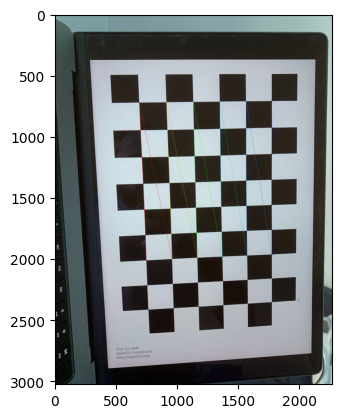

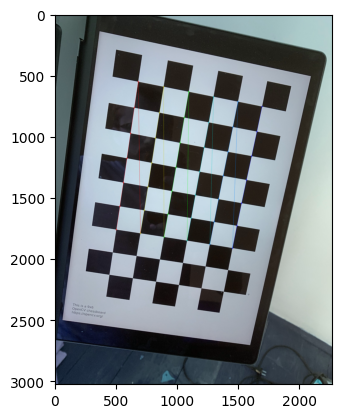

In [3]:

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/calibration/*.jpg')
shape = (row, col) = 2, 4
# fix, ax = plt.subplot(*shape)

for idx, fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()
#         cv.imshow('img', img)
#         cv.waitKey(500)

# cv.destroyAllWindows()

In [4]:
len(imgpoints), len(objpoints)
gray.shape, gray.shape[::-1]
# objpoints

((3024, 2268), (2268, 3024))

In [4]:
# now we're going to calculate  intrinsic matrix of the camera
ret, intrinsic_matrix, distortion_matrix, rot_vecs, trans_vecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

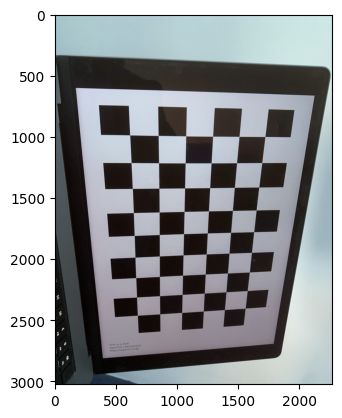

In [6]:
sample = cv.imread(images[0])
plt.imshow(sample)
plt.show()

In [7]:
h,w = sample.shape[:2]
h,w

(3024, 2268)

In [8]:
newcamera_mtx, roi = cv.getOptimalNewCameraMatrix(intrinsic_matrix, distortion_matrix, (w,h), alpha=1, newImgSize=(w,h))
newcamera_mtx, roi

(array([[2.40819439e+03, 0.00000000e+00, 1.12634833e+03],
        [0.00000000e+00, 2.42979726e+03, 1.50848864e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 (90, 114, 2081, 2793))

### undistort image using `cv.undistort`

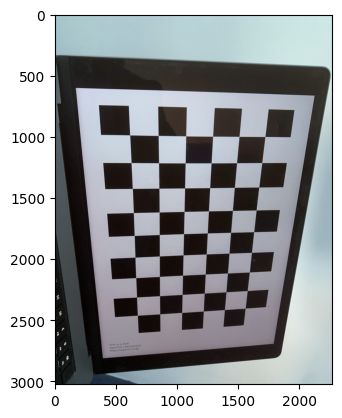

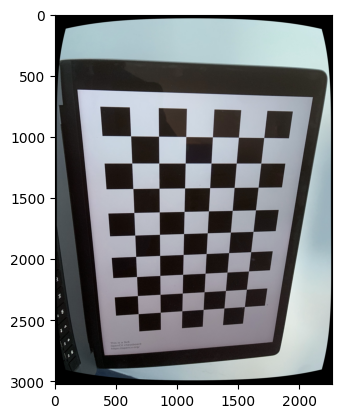

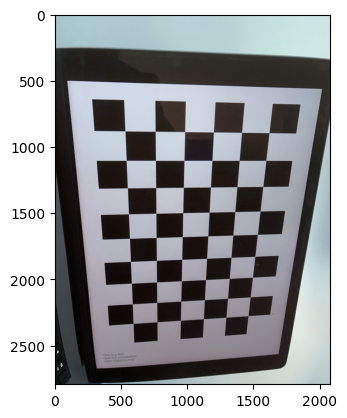

In [ ]:

dst = cv.undistort(sample, intrinsic_matrix, distortion_matrix, newcamera_mtx)
x,y,w,h = roi
new_dst = dst[y:y+h, x:x+w]

# plt.imshow(dst)
plt.imshow(sample)
plt.show()
plt.imshow(dst)
plt.show()
plt.imshow(new_dst)
plt.show()

### undistort image using  `cv.initUndistortRectifyMap`

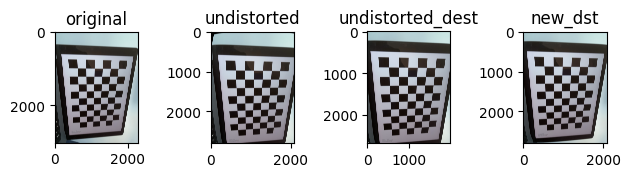

In [19]:
mapx, mapy = cv.initUndistortRectifyMap(intrinsic_matrix, distortion_matrix, None, newcamera_mtx, (w,h), 5)
undistorted = cv.remap(sample, mapx, mapy, cv.INTER_LINEAR)

# crop the image
x,y,w,h = roi
undistorted_dest = undistorted[y:y+h, x:x+w]


fig, ax = plt.subplots(1, 4)


ax[0].imshow(sample)
ax[0].set_title('original')

ax[1].imshow(undistorted)
ax[1].set_title('undistorted')

ax[2].imshow(undistorted_dest)
ax[2].set_title('undistorted_dest')

ax[3].imshow(new_dst)
ax[3].set_title('new_dst')


plt.tight_layout()
plt.show()



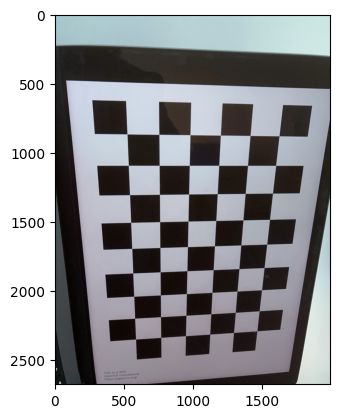

In [17]:
plt.imshow(undistorted_dest); plt.show()

### calculate re-projection error

In [20]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rot_vecs[i], trans_vecs[i], intrinsic_matrix, distortion_matrix)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.048521216478815715


In [21]:
intrinsic_matrix

array([[2.37668293e+03, 0.00000000e+00, 1.12593382e+03],
       [0.00000000e+00, 2.37738109e+03, 1.51127818e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])